## 🚨 Disclaimer

> **⚠️ This project is strictly for educational use only.**
>
> - It is not intended for live or real-money trading.
> - It does not provide financial or investment advice.
> - The developer of this repository is not responsible for any financial loss resulting from the use or misuse of this code.
>
> Use this bot only in test environments or simulations. **Do not connect to real wallets or trading accounts.**
>
> This application does not provide investment advice. All data, models, functions and forecasts are for educational and analytical purposes only. Do not use this information to make investment decisions. All investment decisions are the responsibility of the user.
>
> **WARNING:** This application and all included analyses, data, and forecasts are strictly for educational and analytical purposes only. **Do not use for investment purposes under any circumstances.** The owner of the code assumes no responsibility for any financial, investment, or trading decisions made based on the information provided. **All responsibility lies with the user.**

> **ATTENTION:** In Turkey, investment transactions must only be carried out through intermediary institutions and financial organizations that are authorized and licensed by the Capital Markets Board of Turkey (CMB). This application or code should not be used for investment transactions and must not be considered for investment purposes.

## ⚠️ Yasal Uyarı (Türkçe)

❗️Bu proje **yatırım tavsiyesi değildir**.  
📌 Bu proje sadece **eğitim** amaçlı geliştirilmiştir.

- Herhangi bir finansal ya da yatırım tavsiyesi sunmaz.  
- Bu kodun kullanımından doğabilecek finansal kayıplardan geliştirici sorumlu değildir.  
- Bu bot sadece test ortamlarında veya simülasyonlarda kullanılmalıdır. Gerçek cüzdanlar veya ticaret hesapları ile **bağlantı kurmayınız**.
> Bu uygulama yatırım tavsiyesi içermez. Sunulan veriler, modeller, fonksiyonlar ve tahminler yalnızca eğitim ve analiz amaçlıdır. Yatırım kararlarınızı bu verilerle almanız önerilmez. Her türlü yatırım kararı kullanıcıya aittir.
>
> **UYARI:** Bu uygulama ve içerdiği tüm analizler, veriler ve tahminler yalnızca eğitim ve analiz amaçlıdır. **Kesinlikle yatırım amaçlı kullanmayınız.** Uygulamada yer alan bilgilerle yapılacak herhangi bir yatırım, alım-satım veya finansal işlemden doğacak her türlü sorumluluk kullanıcıya aittir. **Kodun sahibi hiçbir şekilde sorumluluk kabul etmez.**

> **DİKKAT:** Türkiye’de yatırım işlemleri yalnızca Sermaye Piyasası Kurulu (SPK) tarafından yetkilendirilmiş ve lisanslanmış aracı kurumlar ve finansal kuruluşlar aracılığıyla yapılmalıdır. Bu uygulama veya kod, herhangi bir yatırım işlemi için kullanılmamalıdır ve yatırım amacıyla değerlendirilmemelidir.

# 5 Min Bitcoin Forecasting with XGBoost

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

In [ ]:
btc5 = pd.read_csv("btc_data_5min.csv")

In [ ]:
btc5.columns

Index(['timestamp', 'sum_volume_last_5min', 'sum_quote_volume_last_5min',
       'sum_trades_last_5min', 'sum_taker_base_last_5min',
       'sum_taker_quote_last_5min', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote',
       'year', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [ ]:
def add_all_features(df):
    """
    Tek bir DataFrame'e hem teknik analiz hem de hacim/mum formasyon özniteliklerini ekler.
    - target (gelecek kapanış)
    - lag_1 to lag_15 (geçmiş kapanışlar)
    - rolling mean, std, ema
    - getiri oranları
    - hacim değişimi, taker oranı
    - mum formasyonu (high-low ve body)
    """
    df = df.copy()

    # Gelecek kapanış hedefi
    df['target'] = df['close'].shift(-1)

    # Gecikmeli kapanışlar (lag features)
    for i in range(1, 16):
        df[f'lag_{i}'] = df['close'].shift(i)

    # Teknik göstergeler
    df['rolling_mean_5'] = df['close'].rolling(window=5).mean()
    df['rolling_mean_3'] = df['close'].rolling(window=3).mean()
    df['rolling_std_5'] = df['close'].rolling(window=5).std()
    df['ema_5'] = df['close'].ewm(span=5).mean()

    # Getiri oranları
    df['return_1'] = df['close'].pct_change(1)
    df['return_3'] = df['close'].pct_change(3)
    df['return_5'] = df['close'].pct_change(5)

    # Hacim ve taker oranı
    df['volume_change_last_5min'] = df['sum_volume_last_5min'].pct_change()
    df['taker_ratio'] = df['sum_taker_base_last_5min'] / df['volume']

    # Mum çubuğu formasyonları
    df['high_low_range'] = df['high'] - df['low']
    df['candle_body'] = (df['close'] - df['open']).abs()

    return df

In [ ]:
df = add_all_features(btc5)

In [ ]:
df

,timestamp,sum_volume_last_5min,sum_quote_volume_last_5min,sum_trades_last_5min,sum_taker_base_last_5min,sum_taker_quote_last_5min,open,high,low,close,...,rolling_mean_3,rolling_std_5,ema_5,return_1,return_3,return_5,volume_change_last_5min,taker_ratio,high_low_range,candle_body
0,2017-12-31 21:00:00,6.329571,8.836376e+04,56,1.015777,1.417926e+04,13971.95,13974.94,13952.47,13952.82,...,NaN,NaN,13952.820000,NaN,NaN,NaN,NaN,0.160481,22.47,19.13
1,2017-12-31 21:05:00,28.358105,3.951548e+05,395,10.271134,1.431481e+05,13931.35,13936.18,13931.35,13931.35,...,NaN,NaN,13939.938000,-0.001539,NaN,NaN,3.480257,3.156471,4.83,0.00
2,2017-12-31 21:10:00,36.278639,5.049187e+05,370,12.322926,1.715374e+05,13904.48,13976.30,13901.00,13939.27,...,13941.146667,NaN,13939.621579,0.000569,NaN,NaN,0.279304,0.880150,75.30,34.79
3,2017-12-31 21:15:00,22.648970,3.153308e+05,301,6.842605,9.528160e+04,13942.27,13942.27,13911.60,13938.00,...,13936.206667,NaN,13938.948000,-0.000091,-0.001062,NaN,-0.375694,4.090551,30.67,4.27
4,2017-12-31 21:20:00,17.696698,2.467155e+05,366,7.015681,9.782934e+04,13950.00,13950.66,13911.69,13950.00,...,13942.423333,8.909729,13943.190711,0.000861,0.001339,NaN,-0.218653,2.471581,38.97,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773276,2025-05-08 20:40:00,555.621450,5.668331e+07,41482,402.431660,4.104567e+07,102191.29,102206.35,102095.23,102116.03,...,101780.853333,282.085884,101721.313107,0.004857,0.006704,0.007525,1.549878,5.294609,111.12,75.26
773277,2025-05-08 20:45:00,165.911980,1.694951e+07,38348,87.550500,8.944216e+06,102114.10,102127.33,102018.35,102088.38,...,101942.293333,308.988523,101843.668738,-0.000271,0.004767,0.006592,-0.701394,3.945129,108.98,25.72
773278,2025-05-08 20:50:00,85.470730,8.732107e+06,25543,44.471800,4.544078e+06,102117.58,102300.00,102117.58,102280.00,...,102161.470000,309.135987,101989.112492,0.001877,0.006470,0.008320,-0.484843,1.819789,182.42,162.42
773279,2025-05-08 20:55:00,389.936930,3.995750e+07,51551,279.825110,2.867861e+07,102428.57,102685.92,102428.57,102684.64,...,102351.006667,382.633648,102220.954995,0.003956,0.005568,0.010635,3.562228,1.403164,257.35,256.07


In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
print(df[['target', 'close']].head(10))

      target     close
15  13900.41  13884.53
16  13889.64  13900.41
17  13899.02  13889.64
18  13935.00  13899.02
19  13912.90  13935.00
20  13909.00  13912.90
21  13808.70  13909.00
22  13810.00  13808.70
23  13804.29  13810.00
24  13788.83  13804.29


In [ ]:
train_size = int(len(df) * 0.97)
train = df[:train_size]
test = df[train_size:]

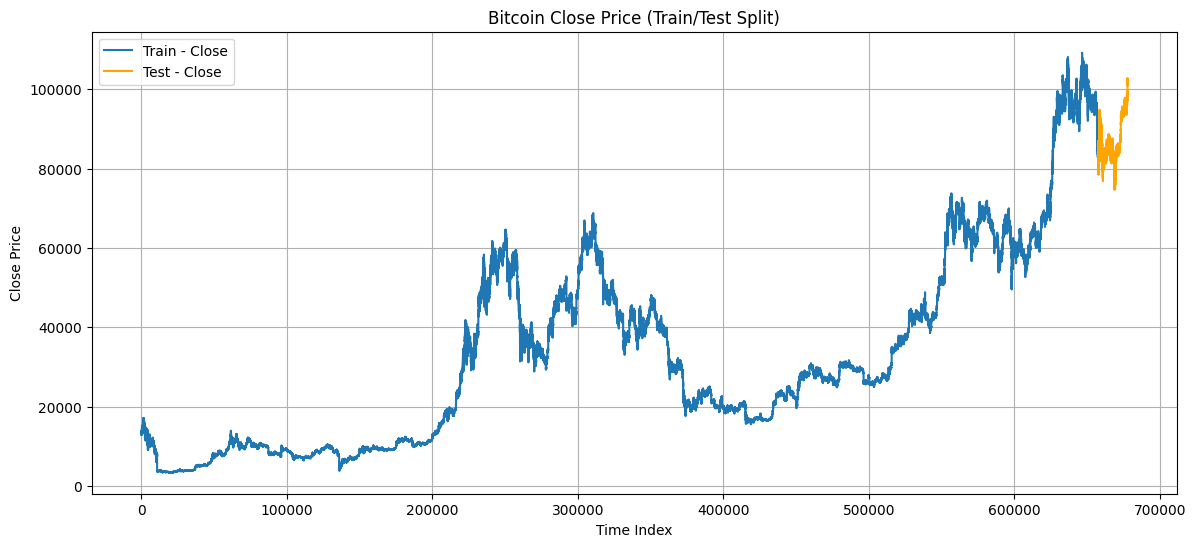

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train['close'].values, label='Train - Close')
plt.plot(range(train_size, len(df)), test['close'].values, label='Test - Close', color='orange')
plt.title('Bitcoin Close Price (Train/Test Split)')
plt.xlabel('Time Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
features = [col for col in train.columns if col not in ['target', 'timestamp']]
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

# Model
xgb = XGBRegressor(random_state=42)

# Random Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0.5, 1.0, 1.5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 3257744.0818
Root Mean Squared Error (RMSE): 1804.9222
Mean Absolute Error (MAE): 1422.2653
R² Score: 0.8818


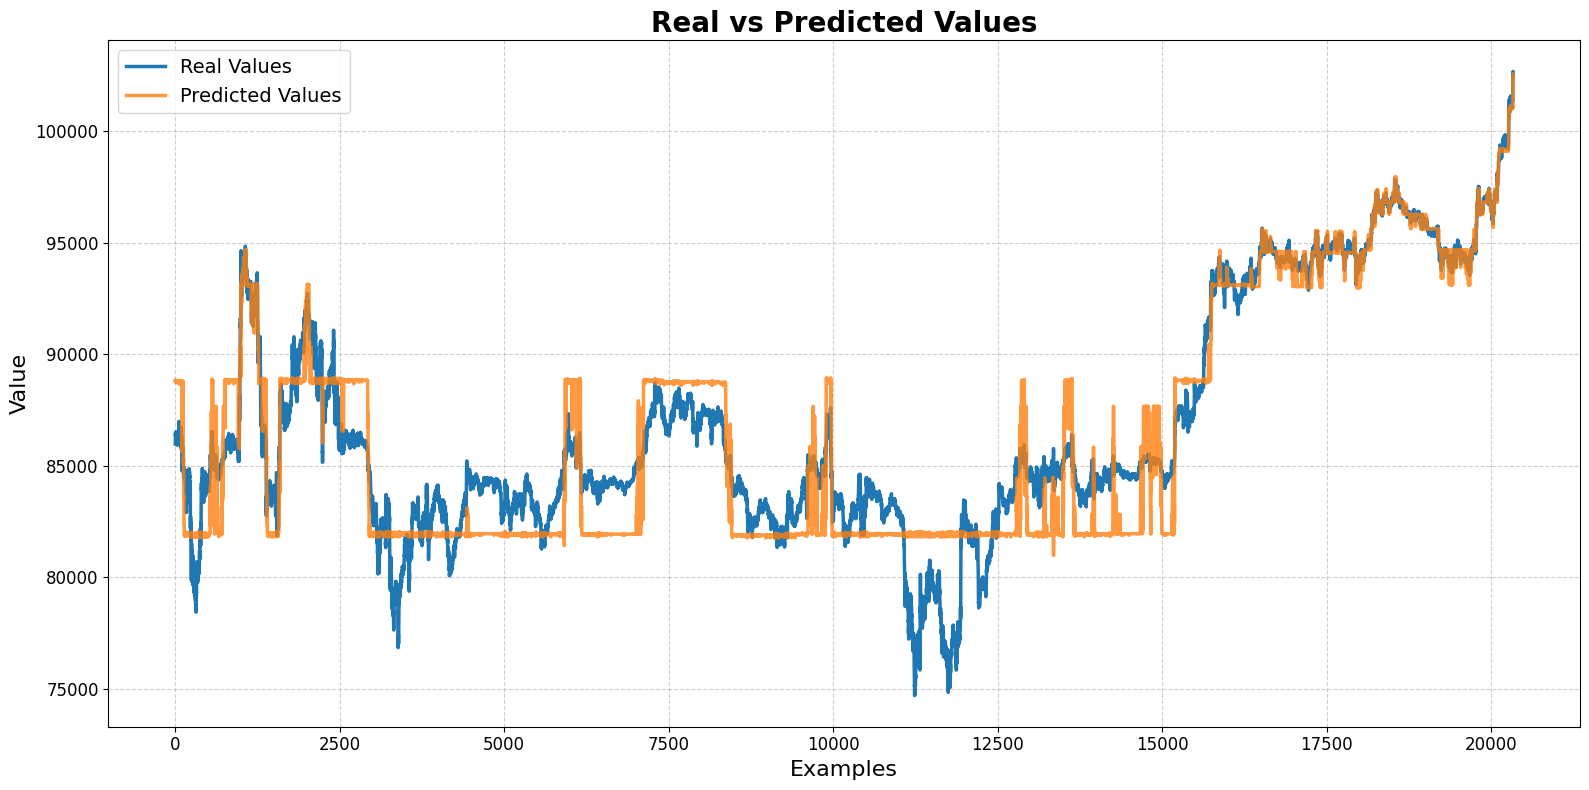

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(y_test.values, label="Real Values", linewidth=2.5)
plt.plot(y_pred, label="Predicted Values", linewidth=2.5, alpha=0.8)
plt.title("Real vs Predicted Values", fontsize=20, fontweight='bold')
plt.xlabel("Examples", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()


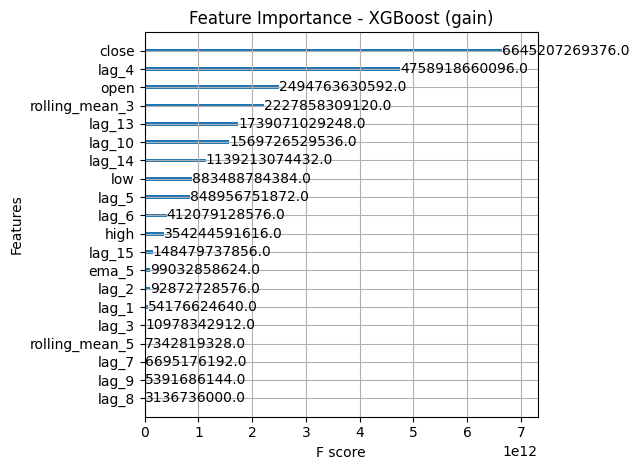

In [ ]:
import xgboost as xgb
xgb.plot_importance(best_model, max_num_features=20, importance_type='gain')
plt.title("Feature Importance - XGBoost (gain)")
plt.tight_layout()
plt.show()